# KFold

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2024-05-13 13:14:02.567182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 13:14:02.679114: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


4 Physical GPUs, 4 Logical GPUs


2024-05-13 13:14:09.846520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 13:14:11.477432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14825 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2024-05-13 13:14:11.478515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14825 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-05-13 13:14:11.479453: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:local

In [2]:
import os

# 데이터셋의 루트 디렉토리
dataset_directory = '/home/jeonk636/ear_classification/eardrumDs'

# 클래스 이름 및 라벨을 매핑하기 위한 딕셔너리 생성
# normal:0, abnormal: 1
label_map = {
    'Aom': 1,
    'Chornic': 1,
    'Earwax': 1,
    'Normal': 0,
    'OtitExterna': 1,
    'tympanoskleros': 1
}

# 이미지 파일 경로 및 라벨을 저장할 리스트
image_paths = []
image_labels = []

# 제외 폴더
exclude_folders = {'Earventulation', 'Foreign', 'PseduoMembran'}

# 각 폴더에 대해 이미지 파일 경로 및 해당 라벨을 리스트에 추가
for label_folder in os.listdir(dataset_directory):
    if label_folder in exclude_folders:  # 이 폴더는 건너뛴다.
        continue
    folder_path = os.path.join(dataset_directory, label_folder)
    
    for image_filename in os.listdir(folder_path):
        # 폴더 내 파일이 실제 파일인지 확인하고 '.ipynb_checkpoints' 폴더를 건너뛴다.
        full_path = os.path.join(folder_path, image_filename)
        if os.path.isfile(full_path) and '.ipynb_checkpoints' not in full_path:
            image_paths.append(full_path)
            image_labels.append(label_map[label_folder])


In [3]:
print(len(image_paths), len(image_labels))

925 925


# Split the Dataset 8:2

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# 이미지 경로와 라벨을 Numpy 배열로 변환
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

# 전체 데이터를 훈련+검증 세트와 테스트 세트로 분할
x_train, x_test, y_train, y_test = train_test_split(
    image_paths, image_labels, stratify=image_labels, test_size=0.2, random_state=42)

In [5]:
print("Train set:", len(x_train))
print("Validation set:", len(x_test))

Train set: 740
Validation set: 185


In [6]:
print("Normal in Train set:", np.count_nonzero(y_train == 0))
print("Abnormal in Train set:", np.count_nonzero(y_train == 1))

Normal in Train set: 427
Abnormal in Train set: 313


# Data 증강

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random

In [8]:
def flip_H(image):
    return tf.image.flip_left_right(image)

def flip_V(image):
    return tf.image.flip_up_down(image)

def rotate(image):
    angle = random.uniform(0, 360)
    rotated = tf.image.rot90(image, k=int(angle // 90))
    return rotated

In [9]:
def CLAHE(image):
    image = (image.numpy() * 255).astype(np.uint8)
    # RGB 채널을 BGR로 변경
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # 각 채널에 CLAHE 적용
    channels = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8)) #2.0
    clahed_channels = [clahe.apply(c) for c in channels]
    clahed_image = cv2.merge(clahed_channels)
    # 다시 RGB 채널로 변경
    clahed_image = cv2.cvtColor(clahed_image, cv2.COLOR_BGR2RGB)
    # 이미지를 [0, 1] 범위로 정규화
    clahed_image = clahed_image / 255.0
    return clahed_image

def RandomContrast(image):
    lower, upper = 0.5, 2.0 
    return tf.image.random_contrast(image, lower=lower, upper=upper)

def RandomBrightness(image):
    bright_image = tf.image.random_brightness(image, max_delta=0.3)
    bright_image = tf.clip_by_value(bright_image, 0.0, 1.0)  # 클리핑
    return bright_image

def Blur(image):
    image = image.numpy()
    kernel_size = random.choice([(5, 5), (7, 7), (9, 9), (13,13)])
    return cv2.blur(image, kernel_size)


In [10]:
normal_indices = [i for i, label in enumerate(y_train) if label == 0] 
abnormal_indices = [j for j, label in enumerate(y_train) if label == 1] 

selected_normal_images = [(x_train[i]) for i in normal_indices] 
selected_normal_indexs = [(y_train[i]) for i in normal_indices]
selected_abnormal_images = [(x_train[j]) for j in abnormal_indices]
selected_abnormal_indexs = [(y_train[j]) for j in abnormal_indices]

In [11]:
def load_and_preprocess_image(path, target_size=(250, 250)):
    # 이미지를 RGB로 변환하여 로드
    image = Image.open(path).convert('RGB')
    image = image.resize(target_size)  # 목표 크기로 리사이징
    image = np.array(image)  # 이미지를 numpy 배열로 변환
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0  # 텐서로 변환하고 정규화
    return image

In [12]:
aug_func_spatial = {
    'flip_H': flip_H,
    'flip_V': flip_V,
    'rotate': rotate
}

aug_ratio_spatial = {
    'flip_H': 0.3,
    'flip_V': 0.3,
    'rotate': 0.4
}

aug_func_pixel = {
    'CLAHE': CLAHE,
    'RandomContrast': RandomContrast,
    'RandomBrightness': RandomBrightness,
    'Blur': Blur
}

aug_ratio_pixel = {
    'CLAHE': 0.2,
    'RandomContrast': 0.2,
    'RandomBrightness': 0.3,
    'Blur': 0.3
}

def apply_aug_spatial(images, augmentations, ratios):
    augmented_images = []
    func_names = list(augmentations.keys())  # 사전의 키를 리스트로 변환
    probabilities = [ratios[name] for name in func_names]  # 확률 추출
    aug_choice = np.random.choice(func_names, p=probabilities)  # 확률에 따라 선택
    augmented_image = aug_func_spatial[aug_choice](images)  # 증강 함수 적용
    augmented_images.append(augmented_image)
    return augmented_images

def apply_aug_pixel(images, augmentations, ratios):
    augmented_images = []
    func_names = list(augmentations.keys()) 
    probabilities = [ratios[name] for name in func_names]
    aug_choice = np.random.choice(func_names, p=probabilities) 
    augmented_image = aug_func_pixel[aug_choice](images)
    augmented_images.append(augmented_image)
    return augmented_images


In [13]:
def apply_multiple_augmentations(image, aug_func_spatial, aug_ratio_spatial, aug_func_pixel, aug_ratio_pixel):
    # 공간적 증강(spatial augmentation)을 먼저 적용
    spatial_funcs = list(aug_func_spatial.keys())
    spatial_probs = [aug_ratio_spatial[name] for name in spatial_funcs]
    spatial_choice = np.random.choice(spatial_funcs, p=spatial_probs)
    image = aug_func_spatial[spatial_choice](image)

    # 픽셀 기반 증강(pixel-based augmentation)을 적용
    pixel_funcs = list(aug_func_pixel.keys())
    pixel_probs = [aug_ratio_pixel[name] for name in pixel_funcs]
    pixel_choice = np.random.choice(pixel_funcs, p=pixel_probs)
    image = aug_func_pixel[pixel_choice](image)

    return image

In [14]:
random_select_normal = random.choices(selected_normal_images, k=573)

aug_normal = []
for image in random_select_normal:
    tensor = load_and_preprocess_image(image) 
    augmented_image = apply_multiple_augmentations(tensor, aug_func_spatial, aug_ratio_spatial, aug_func_pixel, aug_ratio_pixel)
    aug_normal.append(augmented_image)

aug_normal_label = [0]*573

In [15]:
print(len(random_select_normal))
print(len(aug_normal))
print(len(aug_normal_label))

573
573
573


In [16]:
random_select_abnormal = random.choices(selected_abnormal_images, k=687)

aug_abnormal = []
for image in random_select_abnormal:
    tensor = load_and_preprocess_image(image)
    aug_abnormal.append(apply_multiple_augmentations(tensor, aug_func_spatial, aug_ratio_spatial, aug_func_pixel, aug_ratio_pixel))
    
aug_abnormal_label = [1]*687

In [17]:
print(len(aug_abnormal))
print(len(aug_abnormal_label))

687
687


In [18]:
x_train = [load_and_preprocess_image(path) for path in x_train]
x_test = [load_and_preprocess_image(path) for path in x_test]

In [19]:
# NumPy 배열로 변환 (필요한 경우)
y_train = np.array(y_train)
y_test = np.array(y_test)

aug_normal_label = np.array(aug_normal_label)
aug_abnormal_label = np.array(aug_abnormal_label)

def resize_image(image, target_size=(250, 250)):
    return tf.image.resize(image, target_size)
    
aug_normal_resized = [resize_image(img) for img in aug_normal]
aug_abnormal_resized = [resize_image(img) for img in aug_abnormal]

x_train_resized = [resize_image(img) for img in x_train]

new_y_train = np.concatenate([y_train, aug_normal_label, aug_abnormal_label])
new_x_train = np.concatenate([x_train_resized, aug_normal_resized, aug_abnormal_resized])
#new_x_train = x_train_resized + aug_normal_resized + aug_abnormal_resized

print(len(new_x_train)) 
print(len(new_y_train))

2000
2000


In [20]:
new_y_train

array([1, 0, 1, ..., 1, 1, 1])

In [21]:
for img in x_train_resized:
    print(img.shape, img.dtype)

(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250, 3) <dtype: 'float32'>
(250, 250,

# K-Fold Cross-Validation

In [22]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

logical_gpus = tf.config.experimental.list_logical_devices ('GPU')
strategy = tf.distribute.MirroredStrategy(logical_gpus)

k_splits = 5
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)

accuracies = []

# K-Fold 교차 검증
with strategy.scope():
    for train_idx, test_idx in kf.split(new_x_train):
        train_images, test_images = new_x_train[train_idx], new_x_train[test_idx]
        train_labels, test_labels = new_y_train[train_idx], new_y_train[test_idx]

        # 모델 정의 및 컴파일
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(250, 250, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(2, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # 모델 훈련
        model.fit(train_images, train_labels, epochs=10, verbose=1)

        # 예측 및 정확도 계산
        predictions = model.predict(test_images)
        predicted_classes = np.argmax(predictions, axis=1)
        accuracy = accuracy_score(test_labels, predicted_classes)
        accuracies.append(accuracy)

# 결과 출력
average_accuracy = np.mean(accuracies)
print(f"Average K-Fold Accuracy: {average_accuracy:.2f}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

2024-05-13 13:14:41.176569: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-13 13:14:43.473378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 13:14:44.334765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 13:14:45.194344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 13:14:45.542987: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-13 13:14:45.543471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 13:14:45.546845: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are us

 1/50 [..............................] - ETA: 12:49 - loss: 0.9900 - accuracy: 0.5312

2024-05-13 13:14:50.180993: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


50/50 [==============================] - 18s 50ms/step - loss: 0.9917 - accuracy: 0.5544
Epoch 2/10
50/50 [==============================] - 2s 45ms/step - loss: 0.8440 - accuracy: 0.5969
Epoch 3/10
50/50 [==============================] - 2s 44ms/step - loss: 0.7658 - accuracy: 0.6388
Epoch 4/10
50/50 [==============================] - 2s 44ms/step - loss: 0.7651 - accuracy: 0.6306
Epoch 5/10
50/50 [==============================] - 2s 44ms/step - loss: 0.7550 - accuracy: 0.6181
Epoch 6/10
50/50 [==============================] - 2s 43ms/step - loss: 0.6757 - accuracy: 0.6456
Epoch 7/10
50/50 [==============================] - 2s 44ms/step - loss: 0.6916 - accuracy: 0.6325
Epoch 8/10
50/50 [==============================] - 2s 43ms/step - loss: 0.6330 - accuracy: 0.6575
Epoch 9/10
50/50 [==============================] - 2s 43ms/step - loss: 0.6110 - accuracy: 0.6794
Epoch 10/10
13/13 [==============================] - 2s 25ms/step
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 18 all-r

2024-05-13 13:15:23.576546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - 10s 44ms/step - loss: 0.8418 - accuracy: 0.5800
Epoch 2/10
50/50 [==============================] - 2s 46ms/step - loss: 0.7014 - accuracy: 0.6244
Epoch 3/10
50/50 [==============================] - 2s 44ms/step - loss: 0.6318 - accuracy: 0.6662
Epoch 4/10
50/50 [==============================] - 2s 44ms/step - loss: 0.6037 - accuracy: 0.6794
Epoch 5/10
50/50 [==============================] - 2s 45ms/step - loss: 0.5648 - accuracy: 0.7113
Epoch 6/10
50/50 [==============================] - 2s 44ms/step - loss: 0.6047 - accuracy: 0.6869
Epoch 7/10
50/50 [==============================] - 2s 43ms/step - loss: 0.5811 - accuracy: 0.6925
Epoch 8/10
50/50 [==============================] - 2s 43ms/step - loss: 0.5732 - accuracy: 0.6994
Epoch 9/10
50/50 [==============================] - 2s 43ms/step - loss: 0.5829 - accuracy: 0.6950
Epoch 10/10
13/13 [==============================] - 2s 15ms/step
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 18 all-r

2024-05-13 13:15:57.827212: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - 11s 45ms/step - loss: 0.9672 - accuracy: 0.5625
Epoch 2/10
50/50 [==============================] - 2s 45ms/step - loss: 0.8625 - accuracy: 0.5719
Epoch 3/10
50/50 [==============================] - 2s 45ms/step - loss: 0.7787 - accuracy: 0.5938
Epoch 4/10
50/50 [==============================] - 2s 43ms/step - loss: 0.7327 - accuracy: 0.6087
Epoch 5/10
50/50 [==============================] - 2s 43ms/step - loss: 0.7003 - accuracy: 0.6306
Epoch 6/10
50/50 [==============================] - 2s 46ms/step - loss: 0.6947 - accuracy: 0.6350
Epoch 7/10
50/50 [==============================] - 2s 43ms/step - loss: 0.6529 - accuracy: 0.6500
Epoch 8/10
50/50 [==============================] - 2s 47ms/step - loss: 0.6089 - accuracy: 0.6744
Epoch 9/10
50/50 [==============================] - 2s 48ms/step - loss: 0.6090 - accuracy: 0.6844
Epoch 10/10
13/13 [==============================] - 2s 15ms/step
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 18 all-r

2024-05-13 13:16:33.153780: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - 10s 45ms/step - loss: 0.9803 - accuracy: 0.5956
Epoch 2/10
50/50 [==============================] - 2s 43ms/step - loss: 0.8548 - accuracy: 0.6181
Epoch 3/10
50/50 [==============================] - 2s 44ms/step - loss: 0.8293 - accuracy: 0.6000
Epoch 4/10
50/50 [==============================] - 2s 44ms/step - loss: 0.7752 - accuracy: 0.6056
Epoch 5/10
50/50 [==============================] - 2s 43ms/step - loss: 0.7353 - accuracy: 0.6244
Epoch 6/10
50/50 [==============================] - 2s 46ms/step - loss: 0.6603 - accuracy: 0.6581
Epoch 7/10
50/50 [==============================] - 2s 44ms/step - loss: 0.6395 - accuracy: 0.6731
Epoch 8/10
50/50 [==============================] - 2s 44ms/step - loss: 0.6285 - accuracy: 0.6612
Epoch 9/10
50/50 [==============================] - 2s 48ms/step - loss: 0.6058 - accuracy: 0.6825
Epoch 10/10
13/13 [==============================] - 2s 15ms/step
Epoch 1/10
INFO:tensorflow:batch_all_reduce: 18 all-r

2024-05-13 13:17:07.970727: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - 10s 44ms/step - loss: 0.9534 - accuracy: 0.5706
Epoch 2/10
50/50 [==============================] - 2s 45ms/step - loss: 0.7580 - accuracy: 0.6181
Epoch 3/10
50/50 [==============================] - 2s 48ms/step - loss: 0.6934 - accuracy: 0.6594
Epoch 4/10
50/50 [==============================] - 2s 43ms/step - loss: 0.7070 - accuracy: 0.6375
Epoch 5/10
50/50 [==============================] - 2s 44ms/step - loss: 0.6923 - accuracy: 0.6594
Epoch 6/10
50/50 [==============================] - 2s 44ms/step - loss: 0.6466 - accuracy: 0.6781
Epoch 7/10
50/50 [==============================] - 2s 43ms/step - loss: 0.6263 - accuracy: 0.6712
Epoch 8/10
50/50 [==============================] - 2s 43ms/step - loss: 0.6103 - accuracy: 0.6894
Epoch 9/10
50/50 [==============================] - 2s 43ms/step - loss: 0.6079 - accuracy: 0.6900
Epoch 10/10
13/13 [==============================] - 2s 15ms/step
Average K-Fold Accuracy: 0.59


### 증강이 잘 적용되었는지 랜덤으로 확인해본 결과 증강이 잘 안 된 경우가 발견됨

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Data type: float32
Min value: -0.342207
Max value: 1.248043


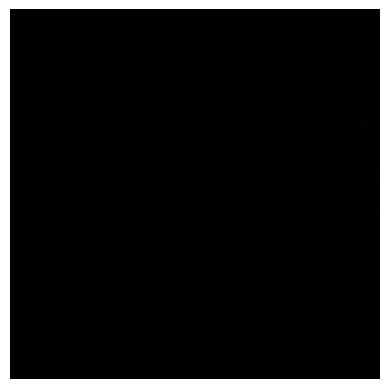

In [46]:
import matplotlib.pyplot as plt

def visualize_image(image_array):
    print("Data type:", image_array.dtype)  # 데이터 타입 확인
    print("Min value:", np.min(image_array))  # 최소값 확인
    print("Max value:", np.max(image_array))  # 최대값 확인

    # 이미지 데이터 정규화 (필요한 경우)
    if np.max(image_array) > 1.0:
        image_array = image_array / 255.0

    plt.imshow(image_array)
    plt.axis('off')
    plt.show()

# 선택된 이미지를 다시 확인
random_index = np.random.randint(0, len(new_x_train))
selected_image = new_x_train[random_index]

# 이미지 시각화 함수 호출
visualize_image(selected_image)
